# Spectral Clustering

In [1]:
import os
import numpy as np
import json
import time
from scipy.sparse import csc_matrix, eye
from scipy.sparse.linalg import eigsh, eigs
from sklearn.cluster import KMeans
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math

In [2]:
# insert path to unzipped MSD data here. In our experience, it can easily handle the test data set, 
# but struggles with train. The histogram output looks less messy with the subset though.
path_dataset = '/Users/yames/Robotics/MMD/project/lastfm_subset'

### Some Functions

In [3]:
def ratio_cuts(laplacian_matrix, fc, cluster_labels):
    """
    Computes optimal (minimum) ratio cut as well as the discrete value for the chosen labels.
    """
    min_cut = np.trace(np.dot(fc.T, laplacian_matrix.dot(fc)))
    print('minimum cut =', min_cut)
    un, inv = np.unique(cluster_labels, return_inverse=True)
    H = np.zeros([len(inv), len(un)])
    H[np.arange(len(inv)), inv] = 1
    H /= np.sum(H, axis=0)**0.5
    disc_cut = np.trace(np.dot(H.T, laplacian_matrix.dot(H)))
    print('discrete cut =', disc_cut)


def delete_unconnected(mat, mask=None):
    """
    Remove the rows and columns denoted by ``mask`` form the CSC sparse matrix ``mat``.
    Used to get rid of unconnected songs or unused tags.
    """
    if not isinstance(mat, scipy.sparse.csc_matrix):
        raise ValueError("works only for CSC format -- use .tocsc() first")
    if mask is None:
        strengths = mat.sum(axis=0).A1
        indices = np.argwhere(strengths == 0).flatten()
        mask = np.ones(mat.shape[1], dtype=bool)
        mask[indices] = False
    temp = mat[:, mask]
    mat = temp.tocsr()
    temp = mat[mask]
    return temp.tocsc()


class IDCounter:
    """
    Keeps track of any string fed to it and creates unique sequential integer IDs for them.
    Used for both the track IDs and the tags.
    """
    def __init__(self):
        self.idict = {}
        self.counter = 0
        self.idlist = []

    def get_numerical(self, key):
        if key in self.idict:
            return self.idict[key]
        else:
            self.idlist.append(key)
            self.idict[key] = self.counter
            self.counter += 1
            return self.counter-1

### SpectralClustering Class

In [4]:
class SpectralClustering:
    def __init__(self, path='./lastfm_subset/', k_clusters=10, g_threshold=50, n_eigenvectors=1):
        """
        :param path:        location of the folder containing all the last.fm json files
        :param k_clusters:  amount of clusters to compute.
        :param g_threshold: minimum count required for a tag to be included
        :param n_eigenvectors:     number of eigenvectors to use for clustering (at least 1)
        """
        self.path = path
        self.k_clusters = k_clusters
        self.g_threshold = g_threshold
        self.n_eigenvectors = n_eigenvectors if n_eigenvectors > 1 else 1
        self.id_counter = IDCounter()
        self.tag_counter = IDCounter()
        self.similarity_matrix, self.song_names, self.tag_matrix, self.is_named = self.load_json_data()
        
        # we read every single tag and track ID ever mentioned in the dataset. when using subset, this results
        # in a lot of unused or unconnected components, which we get rid of here:
        print('before pruning: num tracks =', self.similarity_matrix.shape[0], '; num tags =', self.tag_matrix.shape[1])
        self.prune_matrix()
        print('after pruning: num tracks =', self.similarity_matrix.shape[0], '; num tags =', self.tag_matrix.shape[1])

        # strength is a common name for the degree of a node in networks with weighted edges
        strengths = self.similarity_matrix.sum(axis=0).A1
        strength_matrix = csc_matrix((strengths, [np.arange(len(strengths))] * 2), [len(strengths)] * 2)
        self.laplacian_matrix = strength_matrix - self.similarity_matrix
        self.labels = np.zeros(len(self.song_names))  # we will need to use this later

    def histogram_plot(self):
        # this is kinda messy, can't quite get this to give a pretty output
        # Settings
        number_bins = 500 # number of bin in histo
        hist_cols = 1     # number of plots in one row

        labels = np.unique(self.labels)
        num_tags = self.tag_matrix.shape[1]

        csr_tags = self.tag_matrix.tocsr()

        tag_counts = np.zeros([len(labels), num_tags])
        class_sizes = np.zeros(len(labels))
        for n, label in enumerate(labels):
            submat = csr_tags[self.labels == label]
            class_sizes[n] = submat.shape[0]
            tag_counts[n] = submat.sum(axis=0).A1

        # Init plot stuff
        plot_rows = int(math.ceil(self.k_clusters / hist_cols))
        gs = gridspec.GridSpec(plot_rows, hist_cols)
        fig = plt.figure()
        fig.suptitle('Spectral Clustering: Tags in each cluster')
        for n, tag_count in enumerate(tag_counts):
            ax = fig.add_subplot(gs[n])    # create new subplot
            #plt.bar(x_axis+n*offs, np.log(tag_count), width=offs, color=colors[n%5], alpha=1, linewidth=0)
            # Plot the stuff
            ax.hist(tag_count, number_bins)
            ax.legend(['Cluster ' + str(n) + ': ' + str(class_sizes[n]) + ' of ' +
                       str(sum(class_sizes))])
            ax.set_yscale('log')
        fig.show()

    def prune_matrix(self):
        # delete unconnected and unnamed components:
        mat = self.tag_matrix.tocsr()
        temp = mat[self.is_named]
        self.song_names = self.song_names[self.is_named]
        self.similarity_matrix = delete_unconnected(self.similarity_matrix, mask=self.is_named)
        temp = temp[self.similarity_matrix.sum(axis=0).A1 > 0]
        self.tag_matrix = temp.tocsc()

        # an array of all the tags that are still left in the dataset with non-zero count:
        self.pruned_tags = np.asarray(self.tag_counter.idlist)[self.tag_matrix.sum(axis=0).A1 > 0]
        self.tag_matrix = self.tag_matrix[:, self.tag_matrix.sum(axis=0).A1 > 0]
        self.song_names = self.song_names[self.similarity_matrix.sum(axis=0).A1 > 0]
        self.similarity_matrix = delete_unconnected(self.similarity_matrix)

    def load_json_data(self):
        t0 = time.time()
        print('Loading data for {} at {}'.format(self.path, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
        # start with a smallish array, grow dynamically
        edges = -np.ones([765, 2], dtype=np.int)
        weights = -np.ones(765, dtype=np.float)
        tags = -np.ones([543, 2], dtype=np.int)
        song_names = np.empty([900], dtype='<U64')
        is_named = np.zeros([900], dtype=bool)

        # count how big the arrays need to be
        edge_index = 0
        tag_index = 0

        # dirwalk over all json files
        for root, dirs, files in os.walk(self.path):
            for name in files:
                if name.endswith(".json"):
                    # who the ???? is jason?
                    jason = json.load(open(root + '/' + name))
                    sequential_number = self.id_counter.get_numerical(jason['track_id'])

                    # read song info
                    if sequential_number >= len(song_names):
                        song_names = np.hstack([song_names, np.empty_like(song_names)])
                        is_named = np.hstack([is_named, np.zeros_like(is_named, dtype=bool)])
                    is_named[sequential_number] = True
                    song_names[sequential_number] = jason['artist'] + ' - ' + jason['title']

                    # read tags
                    this_song_tags = np.asarray(jason['tags'], dtype='<U64')
                    num_tags = len(this_song_tags)
                    if num_tags:
                        this_song_tag_counts = this_song_tags[:, 1].astype(np.int)
                        tags_above_threshold = (this_song_tags[:, 0])[this_song_tag_counts > self.g_threshold]
                        tag_numbers = np.asarray([self.tag_counter.get_numerical(tag) for tag in tags_above_threshold])
                        num_tags = len(tags_above_threshold)
                        if tag_index + num_tags > len(tags):  # dynamically grow array
                            tags = np.vstack([tags, -np.ones_like(tags)])
                        tags[tag_index: tag_index + num_tags, 1] = tag_numbers
                        tags[tag_index: tag_index + num_tags, 0] = sequential_number
                        tag_index += num_tags

                    # read similar songs
                    this_song_edges = np.asarray(jason['similars'])
                    num_edges = len(this_song_edges)
                    if num_edges:  # ignore files that have no similars listed
                        edge_numbers = np.asarray([self.id_counter.get_numerical(edge) for edge in this_song_edges[:, 0]])
                        if edge_index + num_edges > len(edges):  # dynamically grow array
                            weights = np.hstack([weights, -np.ones_like(weights)])
                            edges = np.vstack([edges, -np.ones_like(edges)])
                        weights[edge_index: edge_index + num_edges] = this_song_edges[:, 1].astype(np.float)
                        edges[edge_index: edge_index + num_edges, 1] = edge_numbers
                        edges[edge_index: edge_index + num_edges, 0] = sequential_number
                        edge_index += num_edges

        # reduce array size back to the amount necessary
        edges = edges[:edge_index]
        weights = weights[:edge_index]
        tags = tags[:tag_index]
        song_names = song_names[:self.id_counter.counter]
        is_named = is_named[:self.id_counter.counter]

        # create sparse matrices
        similarity_matrix = csc_matrix((weights, (edges[:, 0], edges[:, 1])), shape=[len(song_names)] * 2)
        tag_matrix = csc_matrix((np.ones(len(tags)), (tags[:, 0], tags[:, 1])), shape=[len(song_names), self.tag_counter.counter])

        # a sparse-compatible version of "np.maximum(mat, mat.T)" to make the matrix symmetrical
        TisBigger = similarity_matrix.transpose() > similarity_matrix
        symmetric_matrix = similarity_matrix - similarity_matrix.multiply(
            TisBigger) + similarity_matrix.transpose().multiply(TisBigger)

        print('parsed json files in {} seconds'.format(time.time()-t0))
        return symmetric_matrix, song_names, tag_matrix, is_named

    def compute_clusters(self, tolerance=1e-6):
        # first compute the largest eigenvalue
        w, v = eigsh(self.laplacian_matrix, k=1)
        largest_eig = w[0]
        
        # spectral shift by the largest eigenvalue
        B = self.laplacian_matrix - eye(self.laplacian_matrix.shape[0]) * largest_eig
        t1 = time.time()
        print('computing {} largest eigenvalues with shift={}, tolerance={} at {}'.format(self.n_eigenvectors, largest_eig, tolerance, time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
        w, v = eigsh(B, k=self.n_eigenvectors+1, tol=tolerance)
        t2 = time.time()
        print('took {} seconds'.format(t2-t1))

        kmeans = KMeans(n_clusters=self.k_clusters).fit(v[:, 1:])
        self.labels = kmeans.labels_
        
        # compute and print ratio cuts:
        ratio_cuts(self.laplacian_matrix, v[:, 1:], self.labels)

        # clusters is returned as a list of arrays of strings, easy enough to look at, but not great for computing with
        # so we transform it into a list of lists of strings.
        grouped_songs = np.argsort(self.labels)
        grouped_labels = self.labels[grouped_songs]
        boundaries = np.hstack([1, grouped_labels[1:] - grouped_labels[:-1], 1])
        boundary_pairs = np.hstack([np.argwhere(boundaries)[:-1], np.argwhere(boundaries)[1:]])
        clusters = []
        for pair in boundary_pairs:
            clusters.append(self.song_names[grouped_songs[pair[0]: pair[1]]])
        return clusters

### Initalize object

In [5]:
clusterer = SpectralClustering(path_dataset)

Loading data for /Users/yames/Robotics/MMD/project/lastfm_subset at 2017-02-07 23:00:22
parsed json files in 10.795944929122925 seconds
before pruning: num tracks = 206505 ; num tags = 3758
after pruning: num tracks = 4562 ; num tags = 2404


### Compute spectral clustering of the dataset

In [6]:
clusters = clusterer.compute_clusters()

computing 1 largest eigenvalues with shift=12.635312760938177, tolerance=1e-06 at 2017-02-07 23:01:03
took 5.807281017303467 seconds
minimum cut = 3.35632233114e-06
discrete cut = 0.00222885337903


### Print out the first 5 entries of each cluster

In [7]:
for i, cluster in enumerate(clusters):
    print('cluster number {} (Length {}):'.format(i, len(cluster)))
    print(cluster[:5])

cluster number 0 (Length 786):
['Cali - résistance' 'Herbstrock - Halt mich'
 'The Kingston Trio - Good News' 'Irwin Goodman - Liverpoolin pokia'
 '潘瑋柏 - Shuo Ni Ai Wo']
cluster number 1 (Length 101):
['Penguin Cafe Orchestra - Horns of the Bull'
 'Alvino Rey & His Orchestra - Steel Guitar Rag'
 'Billy May & His Orchestra - Tenderly'
 'Bert Kaempfert and His Orchestra - Games People Play'
 'Lisa Lynne - Isla Del Luna']
cluster number 2 (Length 91):
['Negură Bunget - Al doilea om' 'Astarte - Oblivious Darkness'
 'Dimmu Borgir - The Fundamental Alienation' 'Finntroll - Ett Norrskensdåd'
 'Nightfall - Death Of Neira']
cluster number 3 (Length 3108):
['Converge - Deep Inside' 'Beastie Boys - Shadrach (2009 Digital Remaster)'
 'Workhorse - High Horse' 'Lily Allen - LDN (Warbox Original Cut Dub)'
 'KT Tunstall - Under The Weather']
cluster number 4 (Length 8):
['Taboo - Sous la Tour Eiffel' 'Taboo - Dab,dab,doo-Party In The Jungle'
 'Hysterie - Imagination' 'Twenty 4 Seven - You Gotta Be Saf

### Plot Histogram

<IPython.core.display.Javascript object>


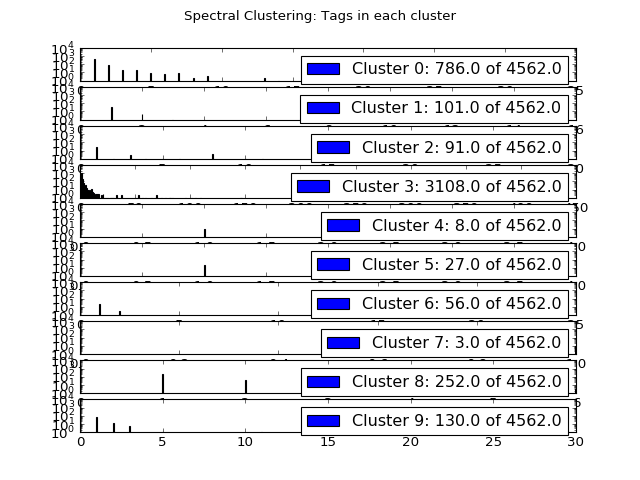

In [8]:
%matplotlib notebook
clusterer.histogram_plot()

### Histogram output

We think that the tag histogram is problematic because there is no known relationship between neighboring tags.
As a result, binning to any major degree is problematic. Ideally we would like to reorder the tags using some
kind of semantic analysis, and then plot the histograms, which we expect to show more pronounced clusters.
Although we looked at ways to do this, we were unable to come up with a satisfying solution, so we must submit
without it.